# 📊 전국 기초자치단체 인프라 지표 시각화 분석 보고서

본 노트북은 전국 226개 기초자치단체의 8대 인프라 데이터를 바탕으로 시각화 및 군집 분석을 수행합니다.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import platform
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('전국_기초자치_인프라_점수.csv')

# 광역시도 정보 추출 (region_name의 첫 단어)
df['sido'] = df['region_name'].apply(lambda x: x.split()[0])

# 인프라 지표 정의
indicators = ['school', 'academy', 'subway', 'department', 'hospital', 'convenience', 'cafe', 'park']

print(f"데이터 로드 완료: {df.shape[0]}개 지역, {df.shape[1]}개 컬럼")
df.head()


데이터 로드 완료: 268개 지역, 12개 컬럼


,sigungu_code,region_name,school,subway,hospital,cafe,academy,department,convenience,park,total_score,sido
0,2720000000,대구광역시 남구,368,351,3781,4529,6138,1339,1401,63,17970,대구광역시
1,2717000000,대구광역시 서구,411,341,3954,4805,6541,1325,1560,796,19733,대구광역시
2,2611000000,부산광역시 중구,319,342,2821,3379,2883,1091,1250,638,12723,부산광역시
3,2614000000,부산광역시 서구,294,325,2521,2996,2367,1086,1115,518,11222,부산광역시
4,2617000000,부산광역시 동구,21,454,3600,4409,131,1123,1541,774,12053,부산광역시


## 1. 지역 추출 및 랭킹 분석

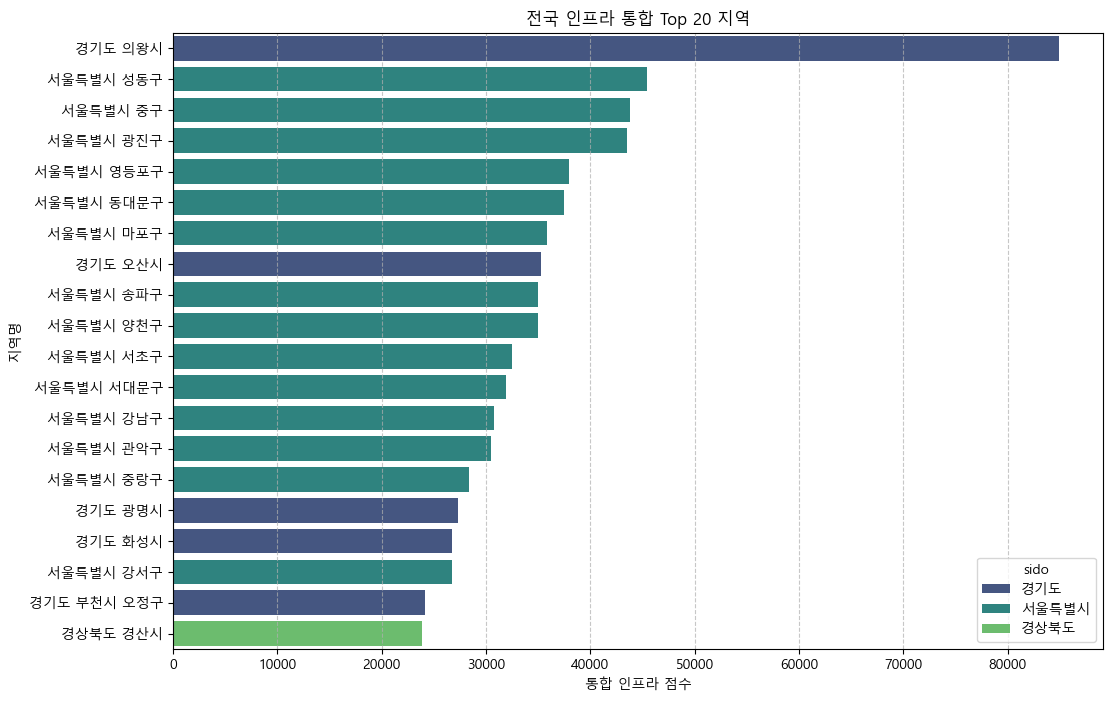

In [2]:

# 1.1 전국 인프라 통합 Top 20 (total_score)
top20 = df.sort_values(by='total_score', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=top20, x='total_score', y='region_name', hue='sido', palette='viridis')
plt.title('전국 인프라 통합 Top 20 지역')
plt.xlabel('통합 인프라 점수')
plt.ylabel('지역명')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [3]:

# 1.2 광역자치단체별(시/도) 상위 20개 지역
sido_list = sorted(df['sido'].unique())

fig = go.Figure()

for sido in sido_list:
    sido_df = df[df['sido'] == sido].sort_values(by='total_score', ascending=False).head(20)
    fig.add_trace(
        go.Bar(
            x=sido_df['total_score'],
            y=sido_df['region_name'],
            orientation='h',
            name=sido,
            visible=(sido == sido_list[0])
        )
    )

# Dropdown 메뉴 생성
buttons = []
for i, sido in enumerate(sido_list):
    visibility = [False] * len(sido_list)
    visibility[i] = True
    buttons.append(dict(
        label=sido,
        method="update",
        args=[{"visible": visibility},
              {"title": f"{sido} 지역 인프라 Top 20"}]
    ))

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.15, y=1
    )],
    title=f"{sido_list[0]} 지역 인프라 Top 20",
    yaxis={'categoryorder':'total ascending'},
    height=600
)

fig.show()


## 2. 평균값 및 상대적 수준 분석

In [4]:

# 2.1 전국 인프라 평균 레이더 차트
avg_scores = df[indicators].mean()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=avg_scores.values,
    theta=indicators,
    fill='toself',
    name='전국 평균'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, avg_scores.max() * 1.2]
    )),
  showlegend=False,
  title='전국 기초자치단체 평균 인프라 구성'
)

fig.show()


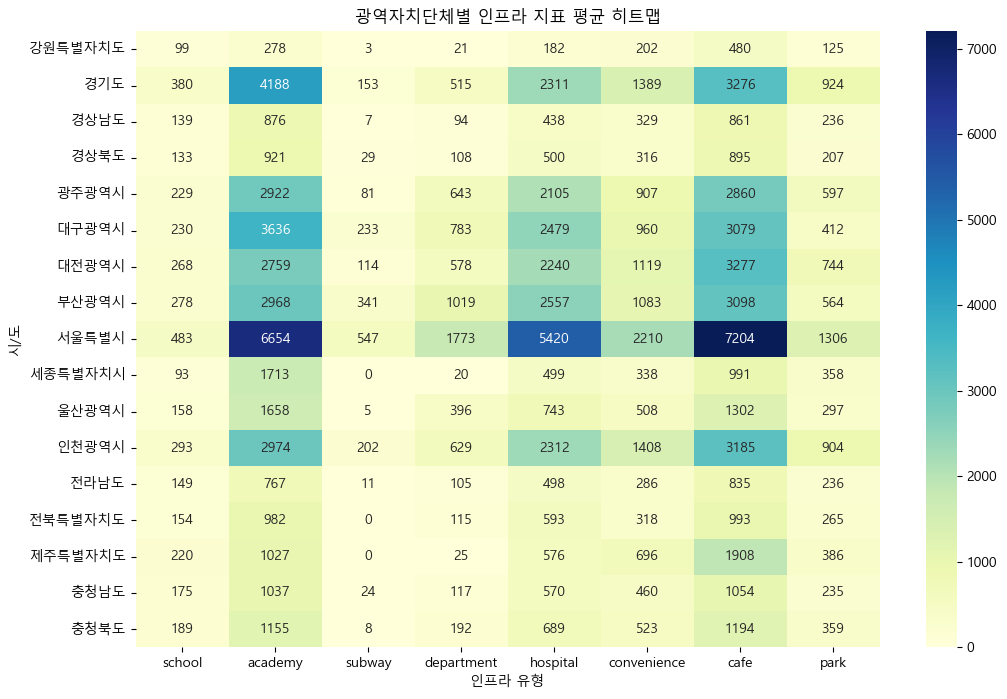

In [5]:

# 2.2 지역별(시/도) 평균 인프라 비교 (Heatmap)
sido_avg = df.groupby('sido')[indicators].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(sido_avg, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('광역자치단체별 인프라 지표 평균 히트맵')
plt.xlabel('인프라 유형')
plt.ylabel('시/도')
plt.show()


## 3. 데이터 분포 및 격차 분석

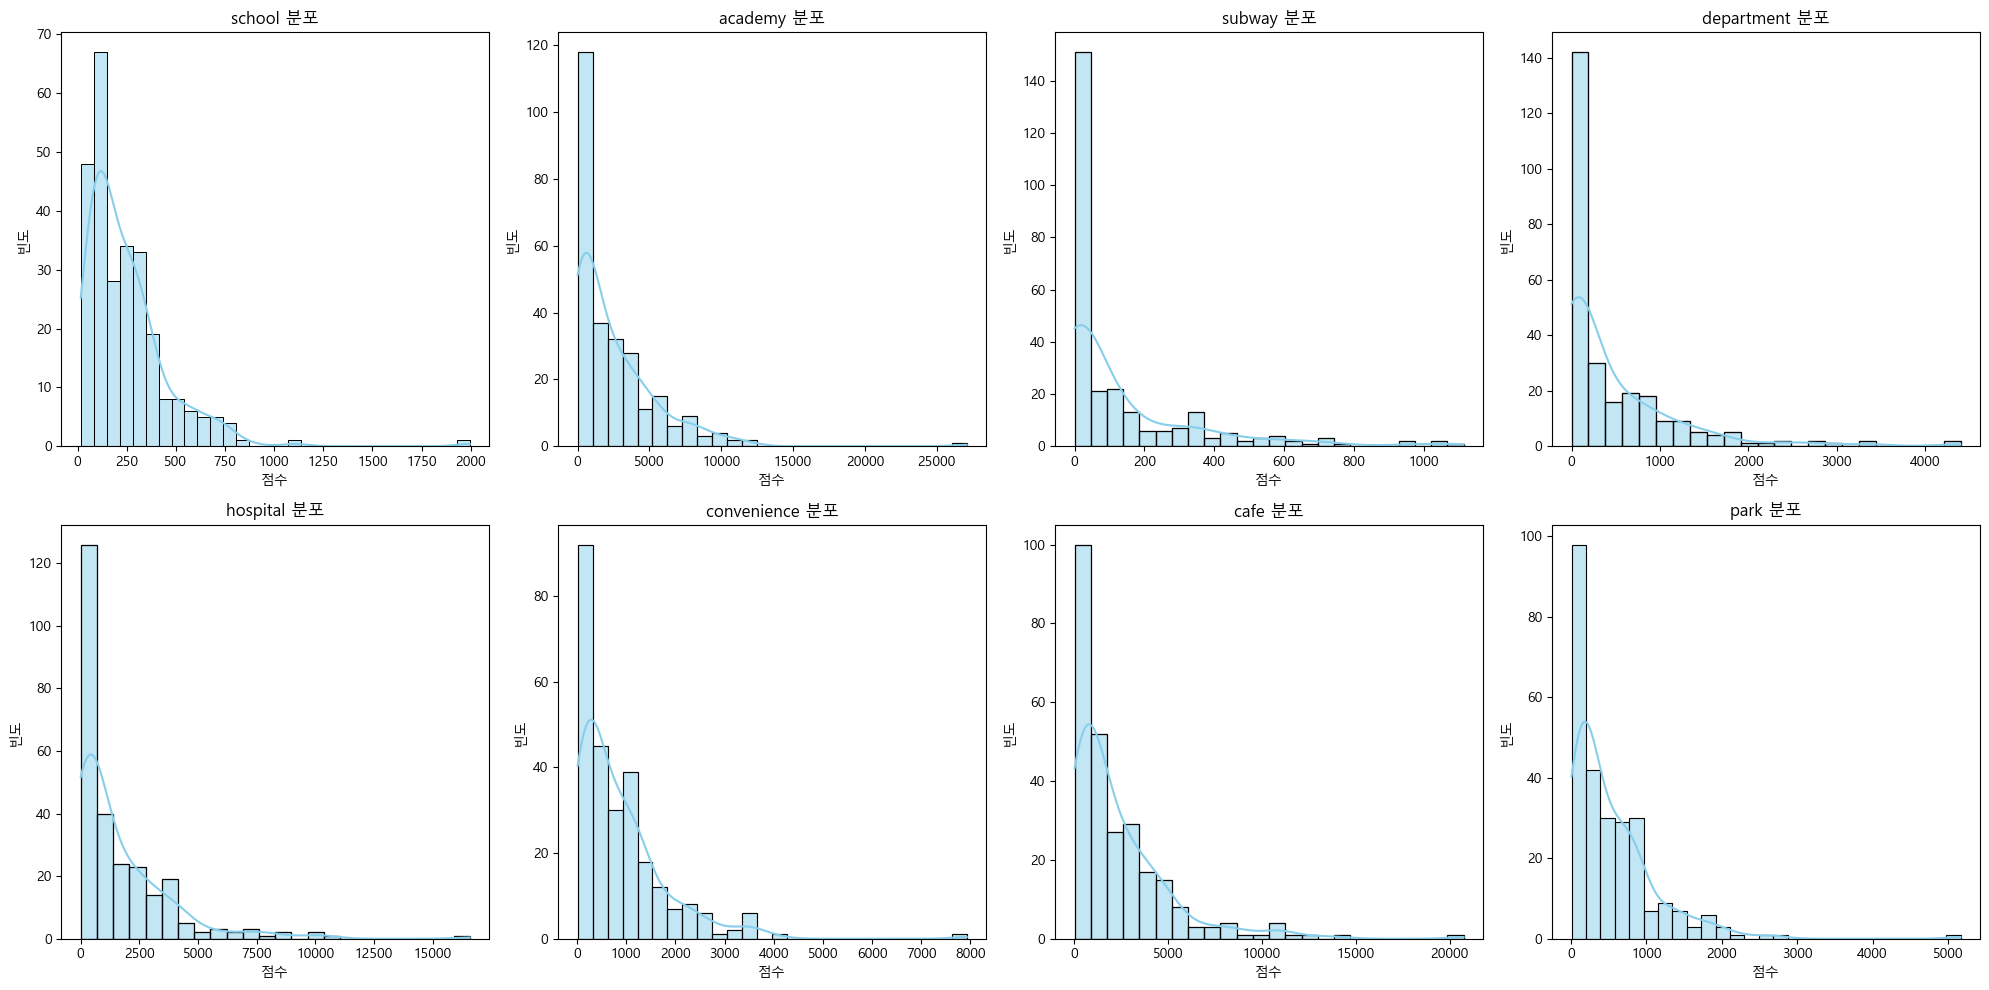

In [6]:

# 3.1 지표별 히스토그램 (2x4 Subplots)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(indicators):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'{col} 분포')
    axes[i].set_xlabel('점수')
    axes[i].set_ylabel('빈도')

plt.tight_layout()
plt.show()


C:\Users\hyon\AppData\Local\Temp\ipykernel_30272\2707813182.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




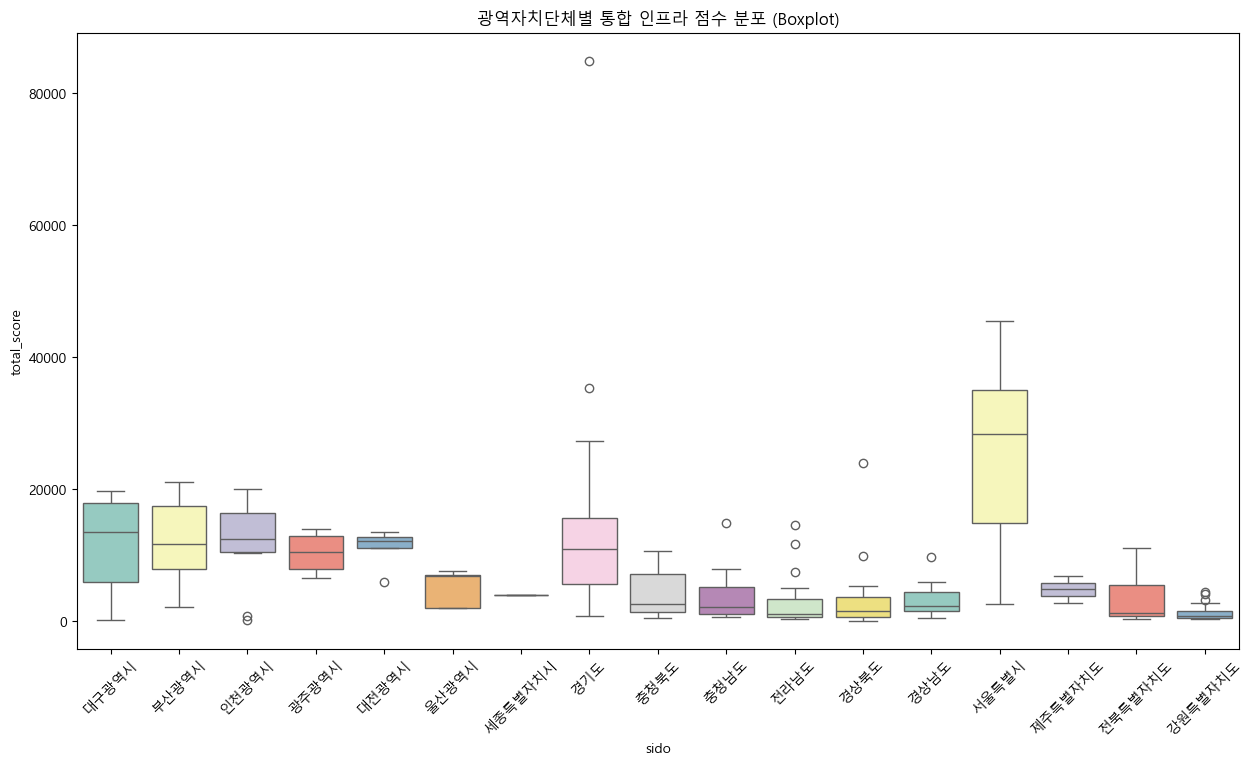

In [7]:

# 3.2 지역별 total_score 분포 박스플롯
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, x='sido', y='total_score', palette='Set3')
plt.xticks(rotation=45)
plt.title('광역자치단체별 통합 인프라 점수 분포 (Boxplot)')
plt.show()


## 4. 변수별 상세 테마 분석

C:\Users\hyon\AppData\Local\Temp\ipykernel_30272\2053471835.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\hyon\AppData\Local\Temp\ipykernel_30272\2053471835.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\hyon\AppData\Local\Temp\ipykernel_30272\2053471835.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\hyon\AppData\Local\Temp\ipykernel_30272\2053471835.py:26: UserWarning:

Glyph 127891 (\N{GRADUATION CAP}) missing from font(s) Malgun Gothic.

C:\Users\hyon\AppData\Local\Temp\ipykernel_30272\2053471835.py:26: UserWarning:

Glyph 12864

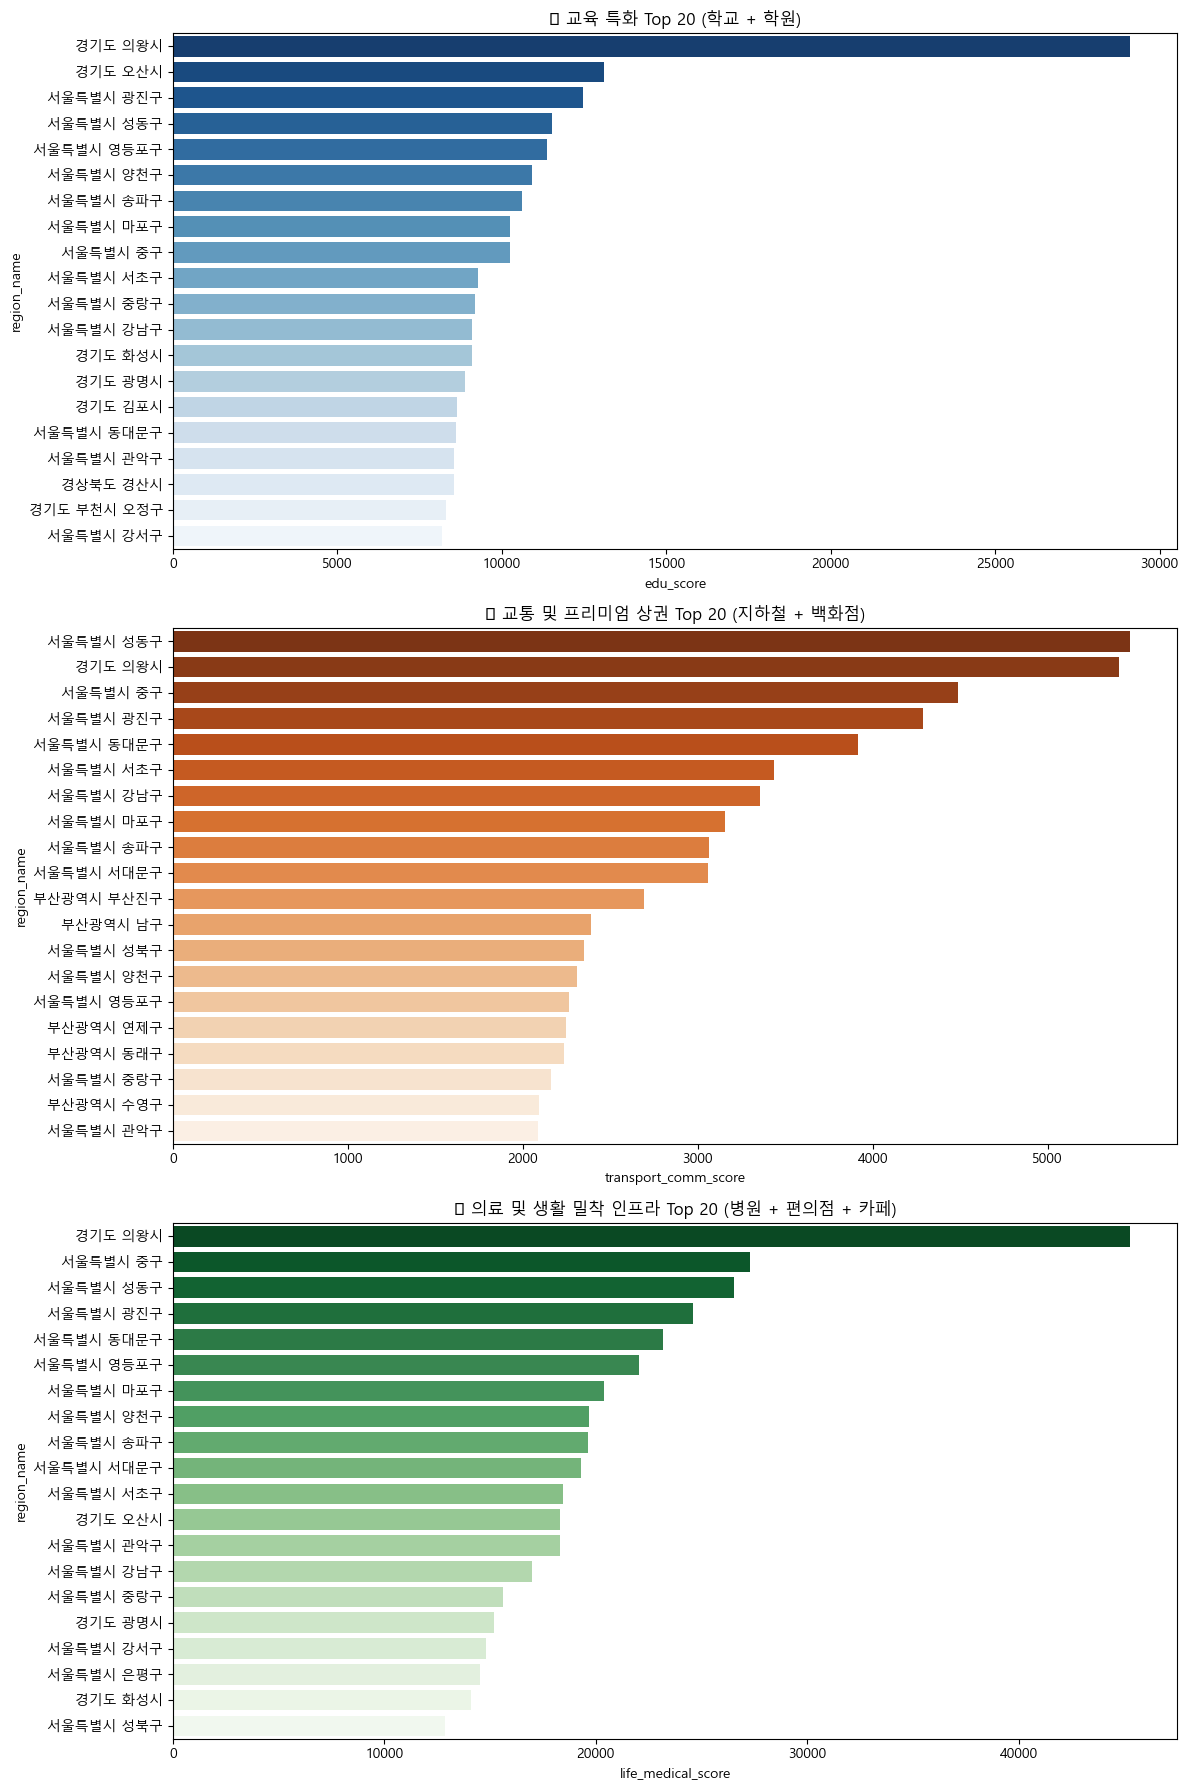

In [8]:

# 4. 변수별 상세 테마 분석 (Top 20)

# 4.1 교육 특화 (학교 + 학원)
df['edu_score'] = df['school'] + df['academy']
top_edu = df.sort_values(by='edu_score', ascending=False).head(20)

# 4.2 교통 및 상권 (지하철 + 백화점)
df['transport_comm_score'] = df['subway'] + df['department']
top_trans = df.sort_values(by='transport_comm_score', ascending=False).head(20)

# 4.3 의료 및 생활 (병원 + 편의점 + 카페)
df['life_medical_score'] = df['hospital'] + df['convenience'] + df['cafe']
top_life = df.sort_values(by='life_medical_score', ascending=False).head(20)

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.barplot(data=top_edu, x='edu_score', y='region_name', ax=axes[0], palette='Blues_r')
axes[0].set_title('🎓 교육 특화 Top 20 (학교 + 학원)')

sns.barplot(data=top_trans, x='transport_comm_score', y='region_name', ax=axes[1], palette='Oranges_r')
axes[1].set_title('🚇 교통 및 프리미엄 상권 Top 20 (지하철 + 백화점)')

sns.barplot(data=top_life, x='life_medical_score', y='region_name', ax=axes[2], palette='Greens_r')
axes[2].set_title('🏥 의료 및 생활 밀착 인프라 Top 20 (병원 + 편의점 + 카페)')

plt.tight_layout()
plt.show()


## 5. 변수 간 상관관계 및 영향도 분석

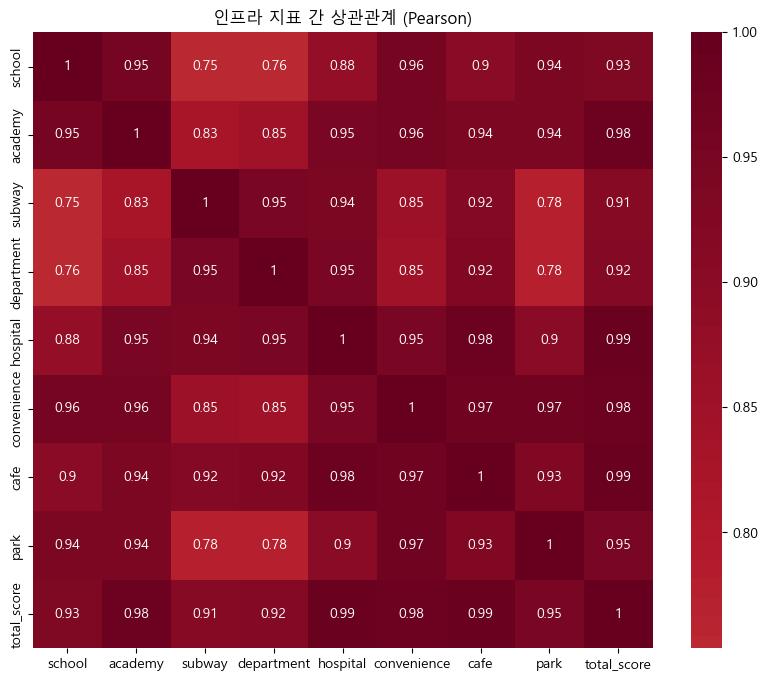

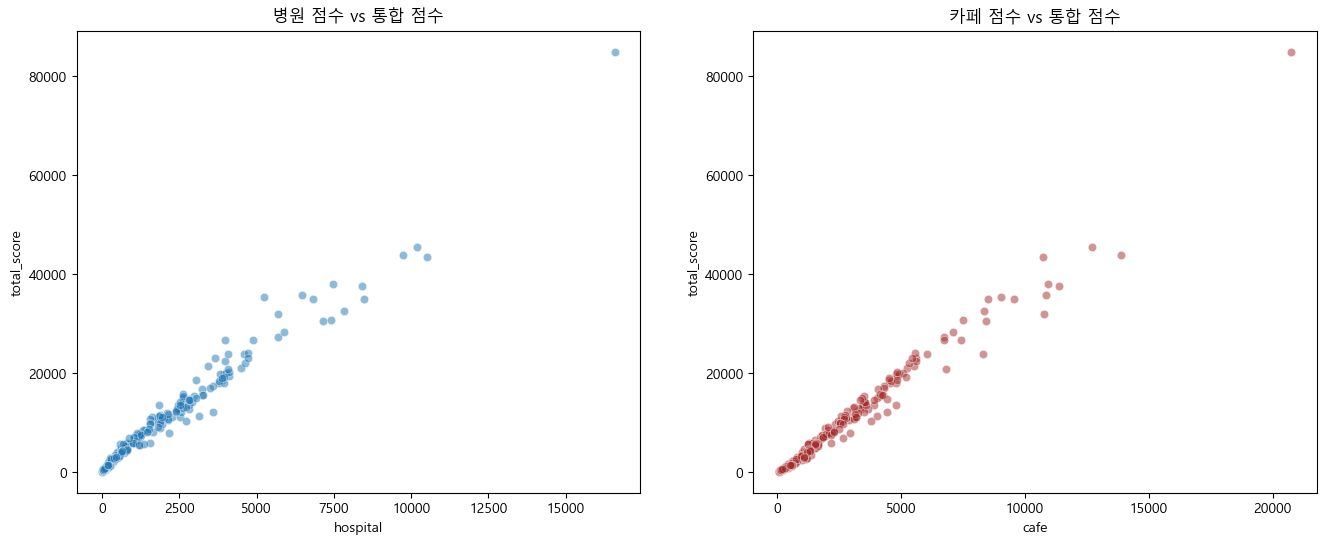

In [9]:

# 5.1 인프라 요소 간 상관관계 Heatmap
plt.figure(figsize=(10, 8))
corr = df[indicators + ['total_score']].corr()
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0)
plt.title('인프라 지표 간 상관관계 (Pearson)')
plt.show()

# 5.2 인프라 비중 분석 (Scatter Plot)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df, x='hospital', y='total_score', alpha=0.5, ax=axes[0])
axes[0].set_title('병원 점수 vs 통합 점수')

sns.scatterplot(data=df, x='cafe', y='total_score', alpha=0.5, ax=axes[1], color='brown')
axes[1].set_title('카페 점수 vs 통합 점수')

plt.show()


## 6. 고급 군집 분석 (Clustering)

c:\Users\hyon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



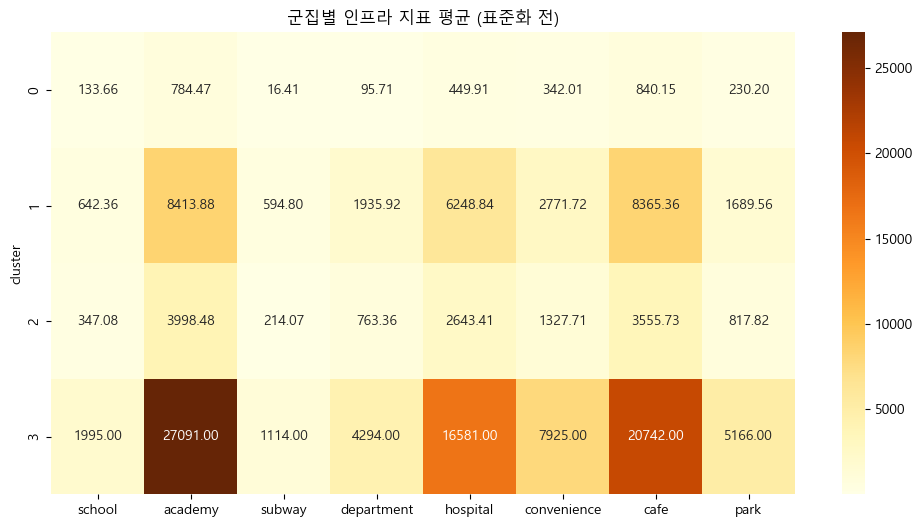

군집별 지역 수:
cluster
0    169
2     73
1     25
3      1
Name: count, dtype: int64


In [10]:

# 6.1 인프라 유형별 지역 분류 (Clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[indicators])

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 군집 특성 분석
cluster_means = df.groupby('cluster')[indicators].mean()

# 군집 이름 정의 (가설에 기반)
# 1. 상업 중심형, 2. 주거 교육형, 3. 의료 특화형, 4. 인프라 소외형
# 각 군집의 평균값을 보고 매칭이 필요하지만, 여기서는 시각화로 보여줌

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="YlOrBr")
plt.title('군집별 인프라 지표 평균 (표준화 전)')
plt.show()

print("군집별 지역 수:")
print(df['cluster'].value_counts())
